##omer vazana, id:318870102

In [1]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

## Dataset Preparation

In [3]:

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation: Random horizontal flip
    transforms.RandomRotation(10),           # Data augmentation: Random rotation
    transforms.ToTensor(),                   # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))     # Normalize with mean 0.5 and std 0.5 (for grayscale images)
])

# Load the Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Explanation:
# - `transforms.RandomHorizontalFlip` randomly flips images horizontally with a 50% probability.
# - `transforms.RandomRotation(10)` applies a random rotation to the image by up to ±10 degrees.
# - `transforms.Normalize((0.5,), (0.5,))` normalizes grayscale images with a single channel.
# - DataLoader organizes data into batches for efficient training and evaluation.



## Visualize Dataset

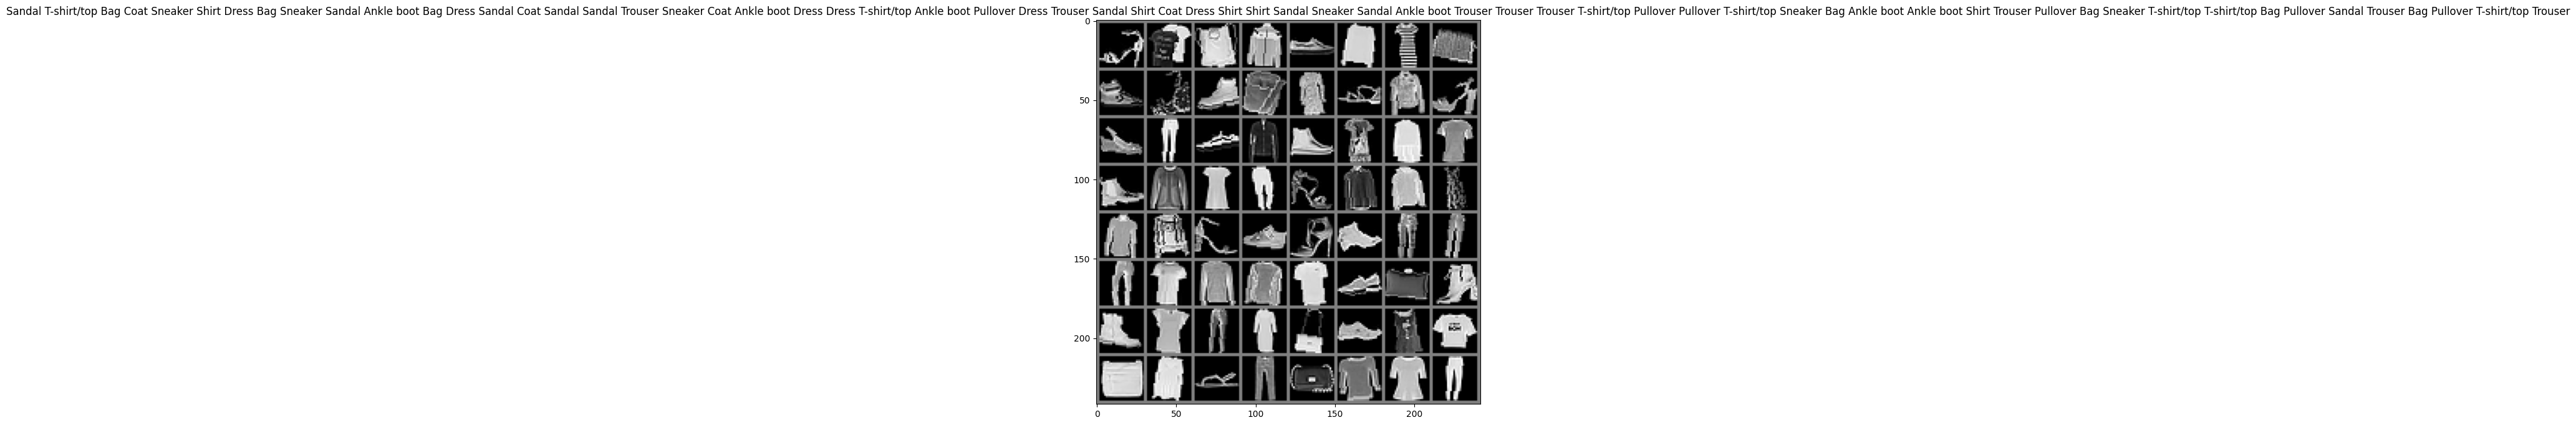

In [4]:

# Define a mapping from label indices to class names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Helper function to display images
def imshow(img, labels):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.title(" ".join([class_names[label] for label in labels]))
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display images
imshow(torchvision.utils.make_grid(images), labels)

# Explanation:
# - `imshow` displays a grid of images and labels using the `class_names` list.
# - Since Fashion-MNIST is grayscale, we use `cmap="gray"` for better visualization.
# - `torchvision.utils.make_grid` arranges a batch of images into a single grid for visualization.


***Model Building***

## Define the CNN Model

In [5]:

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Grayscale input (1 channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)  # Dropout to prevent overfitting
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Adjusted for Fashion-MNIST (28x28 -> 7x7 after pooling)
        self.fc2 = nn.Linear(512, 10)  # 10 output classes for Fashion-MNIST

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + ReLU + Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + ReLU + Pooling
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = self.fc2(x)  # Fully connected layer for output
        return x

# Instantiate the model
model = CNN(dropout=0.3)

# Print the model architecture
print(model)

# Explanation:
# - Adjusted `conv1` to take 1 input channel (grayscale images).
# - Flattening layer is adjusted for input size (28x28 becomes 7x7 after two max-pooling layers with kernel size 2).
# - Output layer size matches the number of classes (10 for Fashion-MNIST).
# - Added dropout to prevent overfitting during training.


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Visualizing Filters

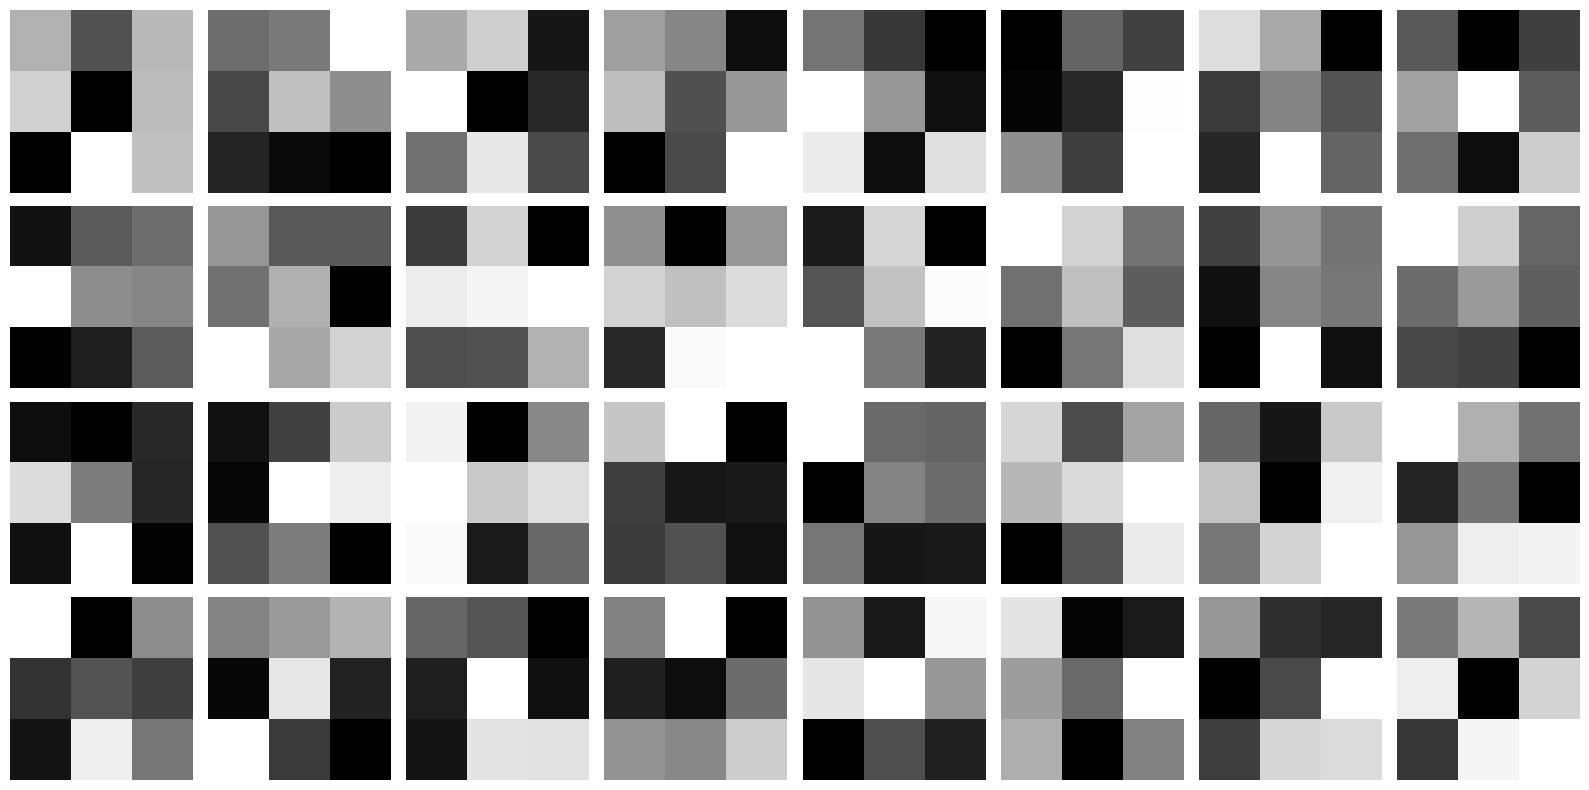

In [6]:

# Function to visualize filters
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    filters = filters - filters.min()  # Normalize filters to range [0, 1]
    filters = filters / filters.max()
    filter_num = filters.shape[0]  # Number of filters
    n_columns = 8
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns * 2, n_rows * 2))
    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        if filters.shape[1] == 1:  # Grayscale filters (1 channel)
            axs[row, col].imshow(filters[i, 0], cmap='gray')  # Visualize as grayscale
        else:  # For RGB filters (3 channels, not applicable here)
            axs[row, col].imshow(filters[i].permute(1, 2, 0))
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

# Instantiate the model
model = CNN()

# Visualize the filters of the first convolutional layer
visualize_filters(model.conv1)


### Visualizing Feature Maps

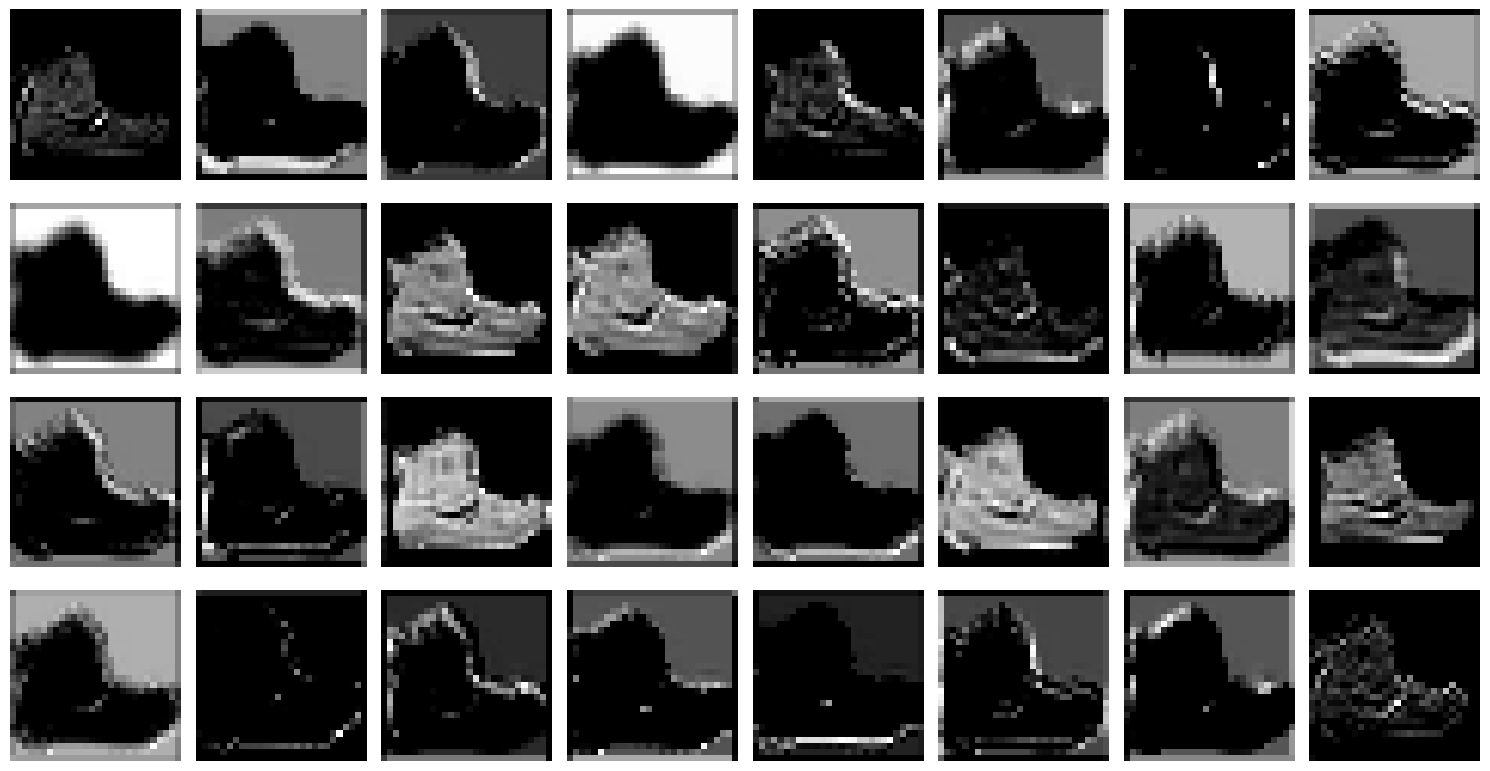

In [7]:

# Function to visualize feature maps
def visualize_feature_maps(image, model):
    x = image.unsqueeze(0)  # Add batch dimension
    x = model.conv1(x)  # Pass through the first convolutional layer
    x = torch.relu(x)  # Apply ReLU activation
    feature_maps = x.detach().squeeze(0)  # Remove batch dimension
    num_maps = feature_maps.shape[0]  # Number of feature maps
    n_columns = 8
    n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
    
    # Plot the feature maps
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_maps):
        row = i // n_columns
        col = i % n_columns
        if row < n_rows:
            axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')  # Grayscale for single-channel maps
            axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

# Select a sample image from the training dataset
sample_image, _ = train_dataset[0]

# Visualize feature maps for the sample image
visualize_feature_maps(sample_image, model)


## Training the Model

c:\Users\TAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10, Train Loss: 0.5140, Val Loss: 0.3689
Epoch 2/10, Train Loss: 0.3652, Val Loss: 0.3235
Epoch 3/10, Train Loss: 0.3188, Val Loss: 0.2936
Epoch 4/10, Train Loss: 0.2930, Val Loss: 0.2626
Epoch 5/10, Train Loss: 0.2735, Val Loss: 0.2576
Epoch 6/10, Train Loss: 0.2568, Val Loss: 0.2553
Epoch 7/10, Train Loss: 0.2440, Val Loss: 0.2383
Epoch 8/10, Train Loss: 0.2336, Val Loss: 0.2412
Epoch 9/10, Train Loss: 0.2288, Val Loss: 0.2374
Epoch 10/10, Train Loss: 0.2168, Val Loss: 0.2279


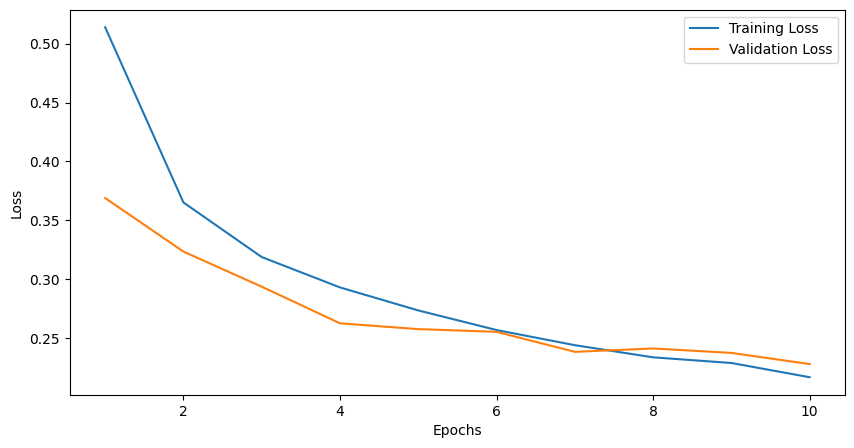

In [8]:

# Data augmentation and normalization for the training set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Normalization for the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Training parameters
num_epochs = 10
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()         # Reset gradients
        outputs = model(inputs)       # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()               # Backward pass
        optimizer.step()              # Update weights
        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(test_loader)
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), "model_weights.pth")


**Evaluation**

## Testing the Model

Test Accuracy: 91.73%

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.87      1000
     Trouser       0.97      0.99      0.98      1000
    Pullover       0.84      0.92      0.88      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.89      0.82      0.85      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.76      0.75      0.76      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



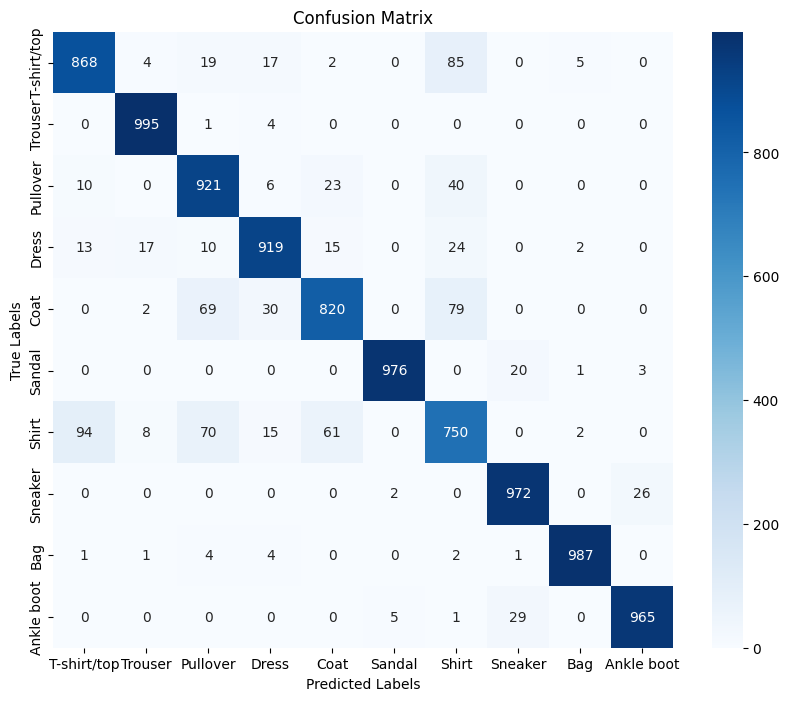

In [9]:

# Evaluate the model on the test set
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Calculate Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**Visualization**

### Visualizing Weights After Training

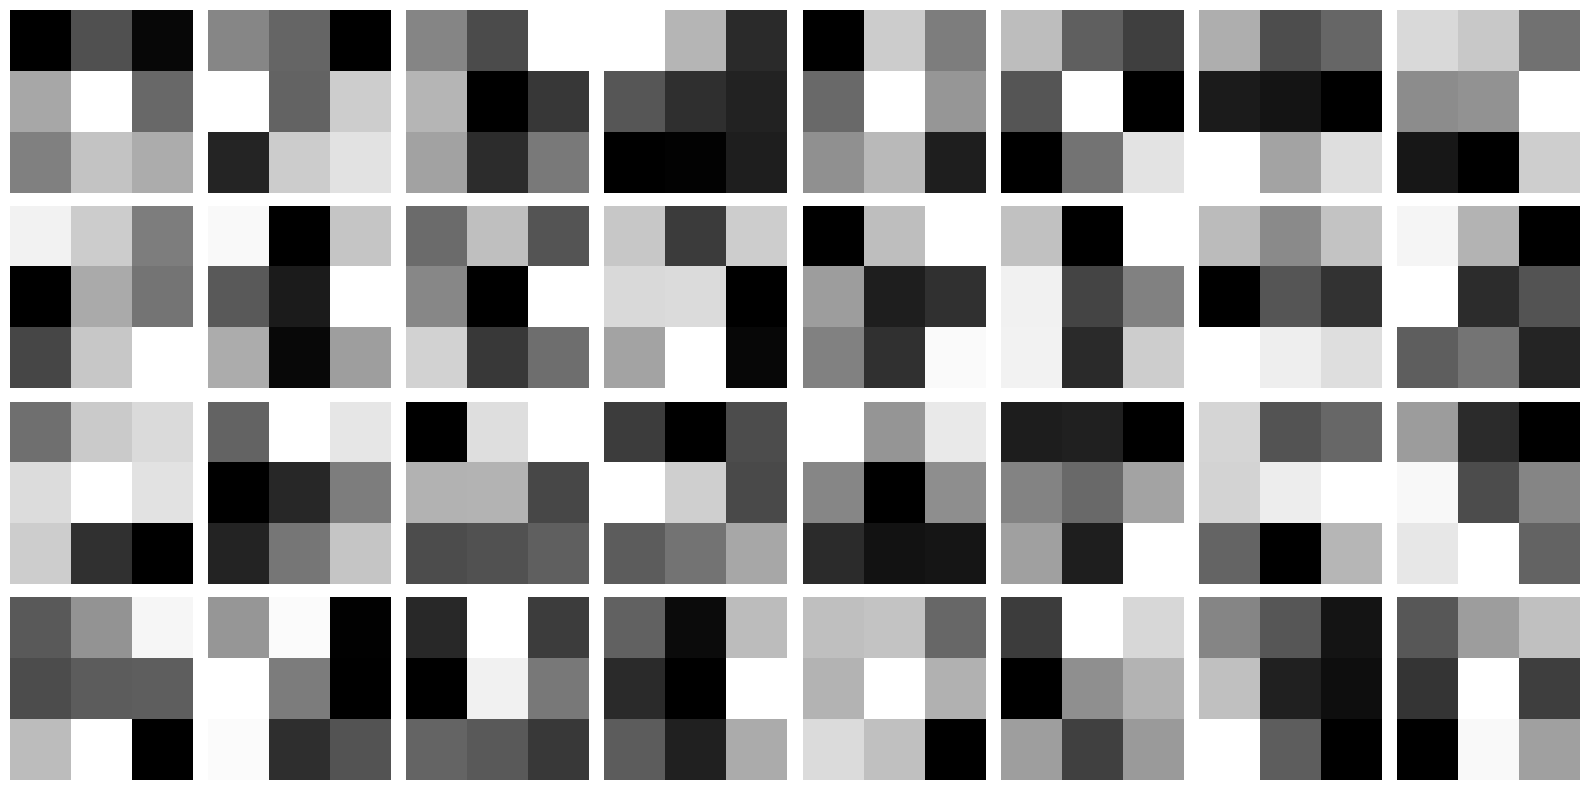

In [10]:
# Visualize the filters of the first convolutional layer after training
model.to("cpu")
visualize_filters(model.conv1)

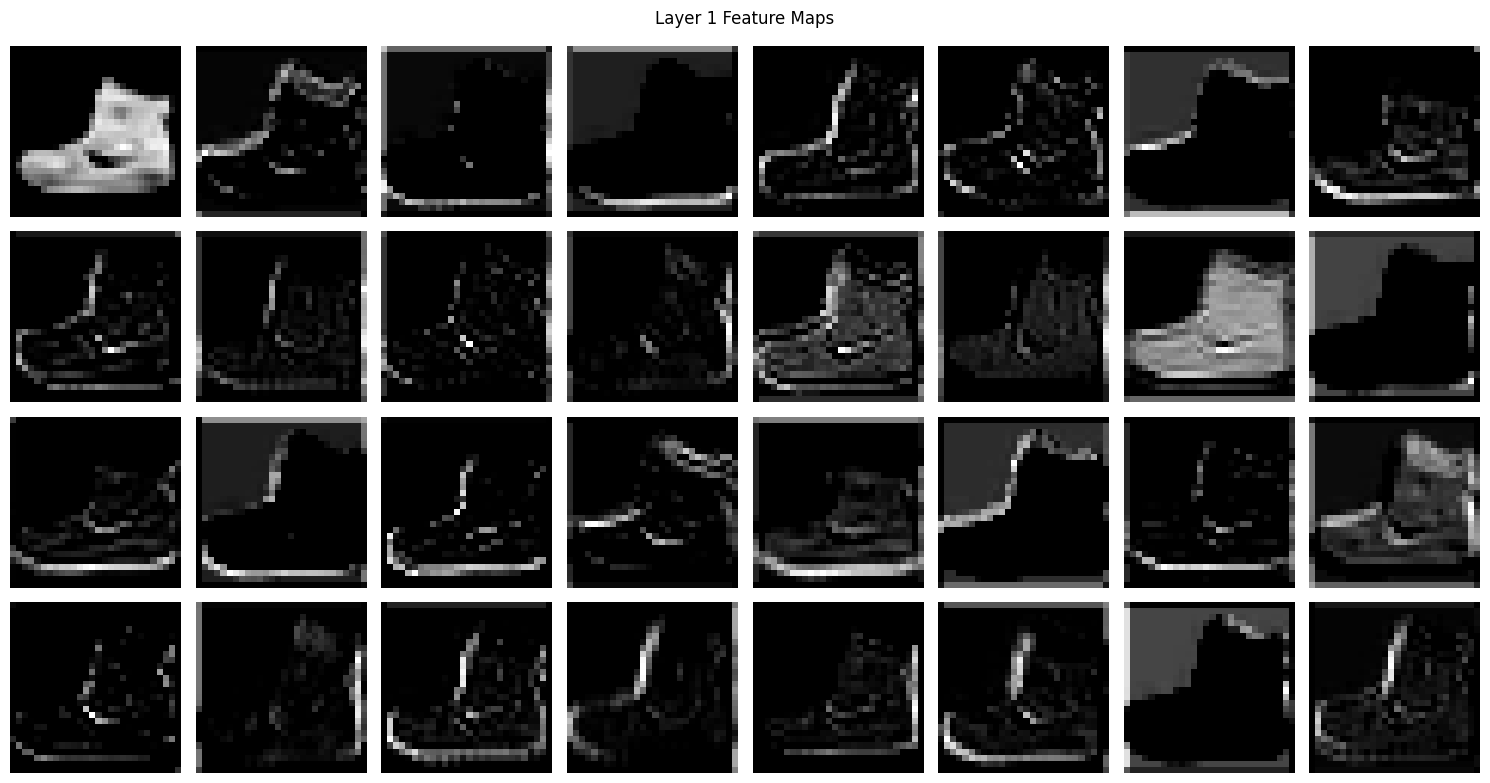

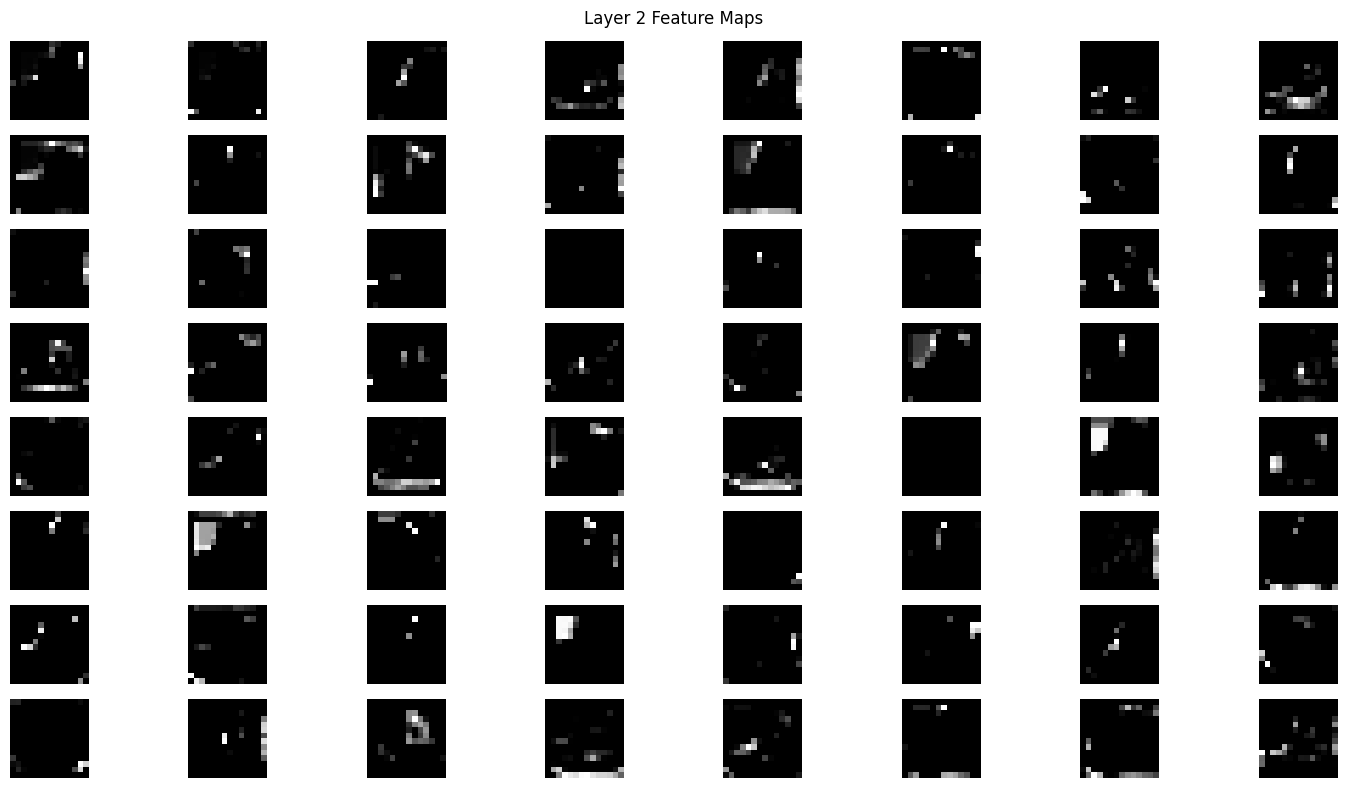

In [11]:

# Visualize the filters of the first convolutional layer
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    filters = filters - filters.min()
    filters = filters / filters.max()
    num_filters = filters.shape[0]
    n_columns = 8
    n_rows = num_filters // n_columns + (num_filters % n_columns > 0)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_filters):
        row = i // n_columns
        col = i % n_columns
        if filters.shape[1] == 1:  # For grayscale filters
            axs[row, col].imshow(filters[i, 0].numpy(), cmap='gray')
        else:  # For RGB filters (not applicable here)
            axs[row, col].imshow(filters[i].permute(1, 2, 0).numpy())
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

## Visualize feature maps at intermediate layers
def visualize_intermediate_layers(image, model):
    activations = []
    x = image.unsqueeze(0)  # Add batch dimension only
    x = model.conv1(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)
    x = model.conv2(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)

    for idx, activation in enumerate(activations):
        feature_maps = activation.detach().squeeze(0)  # Remove batch dimension
        num_maps = feature_maps.shape[0]
        n_columns = 8
        n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
        
        fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
        fig.suptitle(f'Layer {idx+1} Feature Maps')
        for i in range(min(num_maps, n_columns * n_rows)):
            row = i // n_columns
            col = i % n_columns
            axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
            axs[row, col].axis('off')
        plt.tight_layout()
        plt.show()

# Run visualization for a sample image
sample_image, _ = train_dataset[0]
visualize_intermediate_layers(sample_image, model)


In [12]:

# Define the skorch neural net classifier
net = NeuralNetClassifier(
    module=CNN,
    max_epochs=10,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Prepare the data
X_train = np.array([data[0].numpy() for data in train_dataset])  # Convert images to NumPy
y_train = np.array([data[1] for data in train_dataset])          # Convert labels to NumPy

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'lr': [0.01, 0.001],                    # Learning rates to test
    'max_epochs': [5, 10],                  # Epochs to test
    'module__dropout': [0.3, 0.5],          # Dropout rates
    'optimizer': [optim.Adam, optim.SGD],   # Optimizers to test
    'optimizer__weight_decay': [0, 0.0001]  # Weight decay
}

# Perform Grid Search
gs = GridSearchCV(net, param_grid, refit=True, cv=3, scoring='accuracy')

# Fit the model using Grid Search
gs.fit(X_train, y_train)

# Print the best score and parameters
print('Best score:', gs.best_score_)
print('Best parameters:', gs.best_params_)

# Use the best model
best_net = gs.best_estimator_

# Test the best model on test data
X_test = np.array([data[0].numpy() for data in test_dataset])  # Convert test images to NumPy
y_test = np.array([data[1] for data in test_dataset])          # Convert test labels to NumPy

# Evaluate the test accuracy of the best model
test_accuracy = best_net.score(X_test, y_test)
print('Test Accuracy:', test_accuracy)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0601       0.7512        0.6612  5.1368
      2        0.7765       0.7628        0.6390  6.5282
      3        0.7432       0.7648        0.6260  7.0525
      4        0.7218       0.7566        0.6488  7.0307
      5        0.7458       0.7699        0.6198  7.0383
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1439       0.6869        0.8528  5.2057
      2        0.8143       0.7591        0.6576  6.5198
      3        0.7523       0.7712        0.6094  7.0730
      4        0.7328       0.7612        0.6319  7.0910
      5        0.7062       0.7863        0.5564  6.9998
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4016       0.1000        2.3035  5.4018
      2        2.3043       0.1